# Data Science: Click-through rate

**Notebook by Emmanuel Contreras-Campana, PhD**

### Introduction

One of the key applications at TripleLift is a bidder designed to optimize the performance of campaigns. A big driver of this performance is the click through rate (clicks/impressions). We take a sample of company data (<a href="https://s3.amazonaws.com/ops.triplelift.net/public/code-test/data-code-test.tar.gz">data</a>) and use it to develop a model that is able to predict the click through rate.

The columns in the file are:
- **timestamp**: time of the impression
- **placement_id**: a unique identifier for a web page
- **browser_id**: unique identifier for a browser (firefox, chrome, ie10, etc)
- **os_id**: unique identifier for an os (windows, linux, osx)
- **region**: geographic region (states in the US)
- **country**: country code
- **is_adserver**: ignore this column
- **campaign**: unique identifier for a campaign (with it's own targeting parameters - for example target NY +
NJ)
- **creative_asset_id**: unique identifier for an image belonging to a campaign mouseovers: 1 if there was a mouseover
**clicks**: 1 if thee was there a click
- **max_duration**: if this was a video, how far did the viewer get video_length: if this was a video, what was the length of the video viewable: was the ad viewable

### Load Libraries

We load all the necessary python libraries that will permit us to load the data files, pre-process and clean the data, perform data validation, produce statistical summaries, conduct exploratory data analysis, as well as feature transformation, feature ranking, and feature selection. Python libraries will also be needed for model selection, evaluating overfitting, executing standard nested k-fold cross validation for hyper-parameter optimization and model evaluation. 

In [1]:
## Import common python libraries

import sys
import time
import math
import heapq
import os.path
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import random
import operator
import collections

# Import panda library
import pandas.core.common as com
from pandas.tools import plotting
from pandas.tools.plotting import scatter_matrix
from pandas.core.index import Index

# Import scipy
import scipy as sp
from scipy.stats import ks_2samp

# Import itertools
import itertools
from itertools import cycle

# Import collections
from collections import defaultdict, Counter

# Import Jupyter
from IPython.core.interactiveshell import InteractiveShell
from IPython.display import display

# Import scikit-learn
import sklearn

from sklearn.preprocessing import (StandardScaler, RobustScaler, MinMaxScaler,
                                   LabelEncoder, OneHotEncoder)

from sklearn import feature_selection

from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.feature_selection import RFE
from sklearn.feature_selection import RFECV
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import SelectPercentile
from sklearn.feature_selection import f_classif

from sklearn.calibration import calibration_curve, CalibratedClassifierCV

from sklearn.pipeline import make_pipeline, Pipeline

from sklearn.model_selection import ParameterGrid
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold, StratifiedKFold, ShuffleSplit
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import learning_curve

from sklearn.svm import SVC, LinearSVC
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier
from sklearn.ensemble import VotingClassifier, BaggingClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import RandomizedLasso
from sklearn.linear_model import LinearRegression
from sklearn.dummy import DummyClassifier

from sklearn.metrics import (confusion_matrix, roc_auc_score, roc_curve, 
                             auc, average_precision_score, precision_score, 
                             brier_score_loss, recall_score, f1_score, log_loss, 
                             classification_report, precision_recall_curve,
                             accuracy_score)

from sklearn.externals import joblib

# Import imblearn
import imblearn
from imblearn.over_sampling import ADASYN, SMOTE, RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

# Check the versions of libraries/packages
print("Python version " + sys.version)
print("Numpy version " + np.__version__)
print("Pandas version " + pd.__version__)
print("Matplotlib version " + matplotlib.__version__)
print("Seaborn version " + sns.__version__)
print("Scipy version " + sp.__version__)
print("Scikit-learn version " + sklearn.__version__)
print("Imblance version " + imblearn.__version__)

# Fix random seed for reproducibility
seed = 7
random.seed(a=seed)

# Specifying which nodes should be run interactively
#InteractiveShell.ast_node_interactivity = "all"


from lib import dskit

Python version 2.7.13 (default, Apr  4 2017, 08:46:44) 
[GCC 4.2.1 Compatible Apple LLVM 8.0.0 (clang-800.0.42.1)]
Numpy version 1.13.3
Pandas version 0.20.3
Matplotlib version 2.1.0
Seaborn version 0.8.0
Scipy version 0.19.1
Scikit-learn version 0.19.0
Imblance version 0.3.0
Python version 2.7.13 (default, Apr  4 2017, 08:46:44) 
[GCC 4.2.1 Compatible Apple LLVM 8.0.0 (clang-800.0.42.1)]
Numpy version 1.13.3
Pandas version 0.20.3
Matplotlib version 2.1.0
Seaborn version 0.8.0
Scipy version 0.19.1
Scikit-learn version 0.19.0
Imblance version 0.3.0


In [12]:
from lib.dskit import lay_out

In [13]:
print lay_out.__doc__

None


### Load Data Files

Most data files contain approximately 1M entries. There are a total of 8 files totaling 8M data entries. We list the features and response names. We store the data in a Pandas DataFrame for greater ease of data manipulation.

**Note: To reduce running time of the program comment out some of the input files**

In [2]:
%%time
## Load data files

# Feature names
features = ["timestamp", "placement_id", "browser_id", "os_id",
            "region", "country", "is_adserver", "campaign", 
            "creative_asset_id", "mouseovers", "clicks", "max_duration",
            "video_length", "viewable"]

# Check loading data with sc.textFile
baseDir = os.path.join('data')
inputPath = os.path.join('ctr/')
filePath = os.path.join(baseDir, inputPath)

# Load dataset
csvList = []

csvList.append(pd.read_csv(filepath_or_buffer=filePath+"data-0000_part_00", 
                           header = None, delimiter = "|", names = features))
csvList.append(pd.read_csv(filepath_or_buffer=filePath+"data-0001_part_00", 
                           header = None, delimiter = "|", names = features))
csvList.append(pd.read_csv(filepath_or_buffer=filePath+"data-0002_part_00", 
                           header = None, delimiter = "|", names = features))
csvList.append(pd.read_csv(filepath_or_buffer=filePath+"data-0003_part_00", 
                           header = None, delimiter = "|", names = features))
csvList.append(pd.read_csv(filepath_or_buffer=filePath+"data-0004_part_00", 
                           header = None, delimiter = "|", names = features))
csvList.append(pd.read_csv(filepath_or_buffer=filePath+"data-0005_part_00", 
                           header = None, delimiter = "|", names = features))
csvList.append(pd.read_csv(filepath_or_buffer=filePath+"data-0006_part_00", 
                           header = None, delimiter = "|", names = features))
csvList.append(pd.read_csv(filepath_or_buffer=filePath+"data-0007_part_00", 
                           header = None, delimiter = "|", names = features))

df_raw_full = pd.concat(csvList)

print "Total number of events:", df_raw_full.shape[0]                 
print "Number of features:", df_raw_full.shape[1]

Total number of events: 8294824
Number of features: 14
CPU times: user 11.1 s, sys: 2.06 s, total: 13.1 s
Wall time: 13.6 s


In [3]:
%%time
## To decrease the running time even futher we reduce the number of rows 
## of the dataframe to 10k randomly sampled data entries

full = False 

df_raw = df_raw_full if full==True else df_raw_full.sample(n=200000, 
                                                           replace=False, 
                                                           random_state=seed, 
                                                           axis=None)

CPU times: user 1.14 s, sys: 502 ms, total: 1.65 s
Wall time: 1.66 s


### Data pre-processing and cleaning

We investigate the data for any missing values and decide if any feature should be discarded.

In [4]:
%%time
## The following snippet of code was written by Rajashree Baradur
## https://github.com/rajashreebaradur/Kaggle_HousePrices/blob/
## master/getting_cleaning_data.ipynb

# Number of null entries
print df_raw.select_dtypes(include=['int']).isnull().sum(), "\n"
print df_raw.select_dtypes(include=['float']).isnull().sum(), "\n"
print df_raw.select_dtypes(include=['object']).isnull().sum(), "\n"

# Number of non-null entries
print "\nInformation:" 
df_raw.info()

placement_id         0
browser_id           0
os_id                0
is_adserver          0
campaign             0
creative_asset_id    0
mouseovers           0
clicks               0
viewable             0
dtype: int64 

max_duration    199997
video_length    199997
dtype: int64 

timestamp       0
region       4137
country       798
dtype: int64 


Information:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 200000 entries, 173137 to 373382
Data columns (total 14 columns):
timestamp            200000 non-null object
placement_id         200000 non-null int64
browser_id           200000 non-null int64
os_id                200000 non-null int64
region               195863 non-null object
country              199202 non-null object
is_adserver          200000 non-null int64
campaign             200000 non-null int64
creative_asset_id    200000 non-null int64
mouseovers           200000 non-null int64
clicks               200000 non-null int64
max_duration         3 non-null float64
vi

The data is pre-processed and cleaned for any missing values. We drop the "is_adserver" column since it was asked to be ignored. The "max_duration" and "video_length" columns are dropped because there were few instances in which they had any actual values. We will retain the "region" and "country" columns because there are enough entries with actual values.

The "timestamp" column has date and time entries from 10/25/2015. Therefore, we eliminate the extraneous date information and only retain the hour, minute, and second information.

In [5]:
%%time
## Data pre-processing and cleaning (data munging)

# Drop irrelevant columns or columns with too many NaN
df_raw_selected = df_raw.drop(["is_adserver","max_duration","video_length"], 
                              axis=1, inplace=False) 

# Drop rows with at least one NaN
df_raw_selected.dropna(how="any", inplace=True)

# Convert timestamp from string to pandas timestamp
df_raw_selected["timestamp"] = df_raw_selected["timestamp"].apply(pd.Timestamp)

# Extract day of week from pandas timestamp
#df_raw_selected["day_of_week"] = \
#df_raw_selected["timestamp"].apply(lambda t: t.weekday_name)

# Extract hour from pandas timestamp
df_raw_selected["hour"] = df_raw_selected["timestamp"].apply(lambda t: t.hour)

# Remove duplicate entries from dataframe if there are any
df_raw_selected.drop_duplicates(inplace=True)

CPU times: user 1.2 s, sys: 62.9 ms, total: 1.26 s
Wall time: 1.28 s


### Statistical Summary

We give a statistical summary below to make sure the data makes sense and that nothing anomolous is present. As we can see values look promising and have acceptable variances.

In [6]:
%%time
## Calculate class label cpercentages

composition = df_raw_selected.groupby(by="clicks", axis=0).count()["timestamp"]

print composition/composition.sum()

clicks
0    0.995327
1    0.004673
Name: timestamp, dtype: float64
CPU times: user 36.7 ms, sys: 4.63 ms, total: 41.3 ms
Wall time: 40.4 ms


The number of clicks in the data is about 0.46% which suggests that we are dealing with an extremely unbalanced dataset. In all likelihood, we will have to perform some class balancing our data.

In [7]:
%%time
## Print statistical summary of dataset

# To print out all rows and columns to the terminal
pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)

print "Head:"
display(df_raw_selected.head())

print "\nDescribe:"
display(df_raw_selected.describe())

print "Describe based on clicks or non-clicks:"
display(df_raw_selected.groupby('clicks').describe())

Head:


,timestamp,placement_id,browser_id,os_id,region,country,campaign,creative_asset_id,mouseovers,clicks,viewable,hour
173137,2015-10-25 03:07:21,572,12,2,NY,US,326815,16639,0,0,1,3
977087,2015-10-25 23:17:37,6422,13,2,TX,US,326561,10902,1,0,1,23
171926,2015-10-25 03:06:06,6279,4,5,NY,US,328591,15255,0,0,0,3
607857,2015-10-25 16:00:26,4729,13,2,WA,US,326815,16642,0,0,0,16
94774,2015-10-25 01:38:26,4729,3,2,OH,US,326815,16639,0,0,0,1



Describe:


,placement_id,browser_id,os_id,campaign,creative_asset_id,mouseovers,clicks,viewable,hour
count,195826.000000,195826.000000,195826.000000,195826.000000,195826.000000,195826.000000,195826.000000,195826.000000,195826.00000
mean,4888.570941,5.640339,3.398640,327605.623559,14105.544371,0.088063,0.004673,0.402342,12.90297
std,1357.381124,4.424776,2.292546,988.075720,3147.598305,0.283387,0.068196,0.490371,7.62322
min,41.000000,0.000000,0.000000,314838.000000,183.000000,0.000000,0.000000,0.000000,0.00000
25%,4729.000000,3.000000,2.000000,326815.000000,13409.000000,0.000000,0.000000,0.000000,5.00000
50%,4823.000000,3.000000,2.000000,327927.000000,15227.000000,0.000000,0.000000,0.000000,15.00000
75%,5911.000000,11.000000,5.000000,328425.000000,16639.000000,0.000000,0.000000,1.000000,19.00000
max,6684.000000,16.000000,10.000000,328826.000000,16672.000000,1.000000,1.000000,1.000000,23.00000


Describe based on clicks or non-clicks:


browser_id                                                  campaign  \
            count      mean       std  min  25%   50%   75%   max     count   
clicks                                                                        
0        194911.0  5.627312  4.418396  0.0  3.0   3.0  11.0  16.0  194911.0   
1           915.0  8.415301  4.887373  0.0  3.0  11.0  13.0  16.0     915.0   

                                                                           \
                 mean         std       min       25%       50%       75%   
clicks                                                                      
0       327606.047868  988.405907  314838.0  326815.0  327927.0  328425.0   
1       327515.238251  911.030597  323670.0  326815.0  327722.0  328134.0   

                 creative_asset_id                                             \
             max             count          mean          std    min      25%   
clicks                                                                          
0       328826.0          194911.0  14108.386751  3147.540057  183.0  13409.0   
1       328826.0             915.0  13500.067760  3102.850658  183.0  12044.0   

                                       hour                                 \
            50%      75%      max     count       mean       std  min  25%   
clicks                                                                       
0       15227.0  16639.0  16672.0  194911.0  12.910138  7.622336  0.0  5.0   
1       13864.0  15623.0  16643.0     915.0  11.375956  7.661940  0.0  4.0   

                         mouseovers                                          \
         50%   75%   max      count      mean       std  min  25%  50%  75%   
clicks                                                                        
0       15.0  19.0  23.0   194911.0  0.085665  0.279869  0.0  0.0  0.0  0.0   
1       12.0  19.0  23.0      915.0  0.598907  0.490388  0.0  0.0  1.0  1.0   

                os_id                                                \
        max     count      mean       std  min  25%  50%  75%   max   
clicks                                                                
0       1.0  194911.0  3.401537  2.294343  0.0  2.0  2.0  5.0  10.0   
1       1.0     915.0  2.781421  1.766539  1.0  2.0  2.0  3.0  10.0   

       placement_id                                                          \
              count         mean          std   min     25%     50%     75%   
clicks                                                                        
0          194911.0  4886.488295  1357.634515  41.0  4729.0  4822.0  5911.0   
1             915.0  5332.210929  1224.677721  41.0  4729.0  5711.0  6419.0   

                viewable                                               
           max     count      mean       std  min  25%  50%  75%  max  
clicks                                                                 
0       6684.0  194911.0  0.400065  0.489912  0.0  0.0  0.0  1.0  1.0  
1       6626.0     915.0  0.887432  0.316237  0.0  1.0  1.0  1.0  1.0

CPU times: user 554 ms, sys: 25.9 ms, total: 579 ms
Wall time: 582 ms


###  Feature Visualization: Basic Exploratory Data Analyses

We conduct a basic exploratory data analyses by depicting the relationship between **click vs no-click**, and the features. For the investigation of the click through rate we will not make use of "viewable" and "mouseovers" as these are not generally available during real-time bidding of ad impressions. We will keep "hour" but drop "timestamp".

In [8]:
df_raw_selected.drop(['timestamp', 'viewable', 'mouseovers'], axis=1, inplace=True)

We now plot bar graphs to determine if there are any trends between click through rates and any of the features.

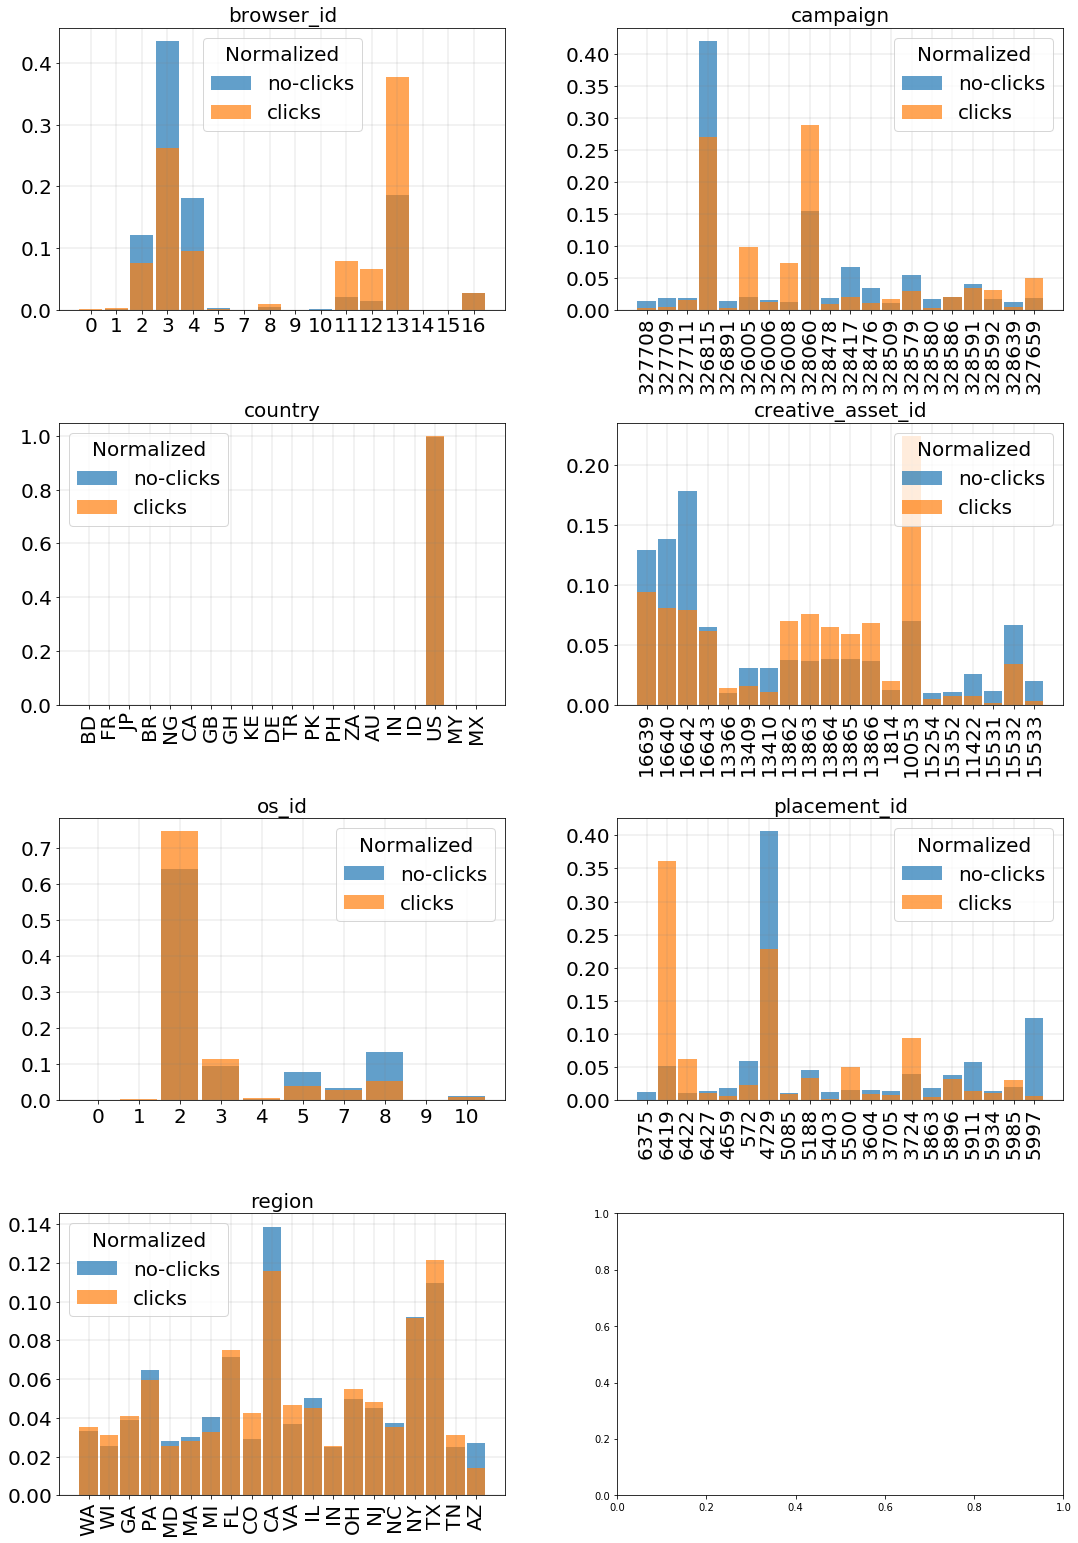

CPU times: user 2.9 s, sys: 82.2 ms, total: 2.98 s
Wall time: 3.02 s


In [10]:
%%time
## Plot bar graph of categorical features

# features
column=['placement_id', 'browser_id', 'os_id', 'region',
        'country', 'campaign', 'creative_asset_id'] # 'day_of_week'

# legend labels
label = ['no-clicks', 'clicks']

# signal and background
signal = df_raw_selected.query('clicks > 0')
background = df_raw_selected.query('clicks < 1')

# plot histograms
dskit.plot_categorical_features(signal, background, columns=column, top_n=20, 
                                normed=True, style=None, legend_label=label)

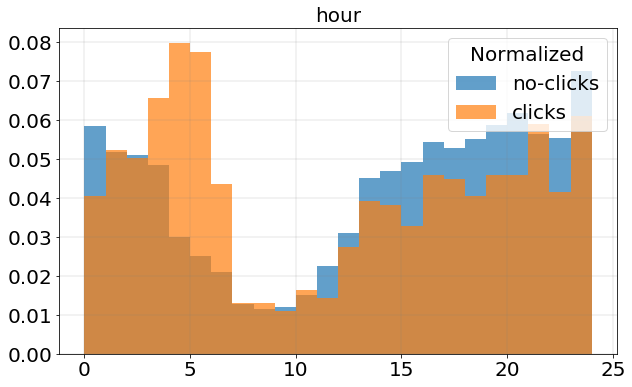

CPU times: user 332 ms, sys: 11.8 ms, total: 344 ms
Wall time: 345 ms


In [59]:
%%time
## Plot hitogram of numerical features

# features
column=['hour']

# legend labels
label = ['no-clicks', 'clicks']

# signal and background
signal = df_raw_selected.query('clicks > 0')
background = df_raw_selected.query('clicks < 1')

# plot histograms
dskit.plot_numerical_features(signal, background, columns=column, 
                              bins=24, normed=True, style=None, 
                              discrete=True, legend_label=label)

### Feature Engineering

Since most machine learning algorithms cannot handle categorical (nominal) features directly we will perform **one-hot-encoding** and then droping them from the original dataframe to eliminate collinearity. We also create the features dataframe and response array which will later on be used for feature ranking and machine learning modeling.

In [12]:
%%time
## Create features dataframe and target array

df_X = df_raw_selected.drop("clicks", axis=1, inplace=False)
df_y = df_raw_selected["clicks"]

# Split data into training and test
X_train, X_test, y_train, y_test = \
       train_test_split(df_X, df_y, test_size=0.33, random_state=seed)

CPU times: user 41.6 ms, sys: 8.87 ms, total: 50.5 ms
Wall time: 49 ms


In [13]:
%%time
## Label encoding

# features to label encode
columns = ['region', 'country']

# label encode
X_train, X_test = dskit.label_encoder(columns, X_train, X_test)

# drop origin "region" and "country" columns
X_train.drop(columns, axis=1, inplace=True)
X_test.drop(columns, axis=1, inplace=True)

CPU times: user 597 ms, sys: 28.2 ms, total: 625 ms
Wall time: 630 ms


In [14]:
%%time
## Feature transformations of categorical (nominal) variables

# One-hot encoding
# Note: sparse=False for numpy.ndarray 
# else sparse=True for scipy.sparse.csr.csr_matrix
enc = OneHotEncoder(categorical_features='all', n_values='auto',
                    sparse=True, handle_unknown='ignore') 

# features to one-hot encode
column = ['placement_id', 'browser_id', 'os_id', 'region_le', 
          'country_le', 'campaign', 'creative_asset_id']

enc.fit(X_train[column])

X_train = enc.transform(X_train[column])
X_test = enc.transform(X_test[column])

CPU times: user 467 ms, sys: 82.7 ms, total: 550 ms
Wall time: 557 ms


We may want to consider **undersampling** of the dataset at this time to reduce the extreme imbalance in class labels. Due to a lack of time currently this will have to be investigated further at a later date.

## Machine Learning Algorithms for Model Building

### Performance of Predictive Modeling Candidates

We investigate several machine learning models in order to establish which algorithm may be the most promising for the predicitve modeling of click through rates. A few performance measurements wil be used to help select our model, namely, **accuracy**, **log loss**, and the **area under the receiver operating characteristic (ROC) curve (AUC)**.

We estiblish our **baseline model** that we use to compare all other candidated models against.

In [15]:
%%time
## Fitting a dummy model (baseline model)
# 'most_frequent', 'stratified'
dc = DummyClassifier(strategy='stratified', random_state=seed) 
dc.fit(X_train, y_train)

# persist model
joblib.dump(dc, 'models/DummyClassifier.pkl')

# Dummy classifier probability predictions
dc_predict_proba = dc.predict_proba(X_test)[:, 1]

# Evaluate model performance with accuracy (i.e. Brier score)
# note: original label composition was 0.996013
score = 1 - brier_score_loss(y_test, dc_predict_proba)

print "baseline (Brier score):", score

baseline (Brier score): 0.990498738839
CPU times: user 14.3 ms, sys: 6.33 ms, total: 20.6 ms
Wall time: 19.2 ms


We consider **Logistic Regression** as our first candidate predictive model.

In [16]:
%%time
## Fitting a logistic regression model with ridge regression
log = LogisticRegression(penalty='l2', C=1, random_state=seed)
log.fit(X_train, y_train)

# persist model
joblib.dump(log, 'models/LogisticRegression.pkl')

# Logistic regression classifier probability predictions
log_predict_proba = log.predict_proba(X_test)[:, 1]

# Evaluate model performance with accuracy (i.e. Brier score)
score = 1 - brier_score_loss(y_test, log_predict_proba)

print "model (Brier score):", score

model (Brier score): 0.994940177747
CPU times: user 522 ms, sys: 17.5 ms, total: 540 ms
Wall time: 540 ms


As we can see there is a **0.5% difference** between the baseline model and our logistic regression model in terms of accuracy. For such an imbalanced dataset accuracy is not an appropriate model performance metric. Log loss provides a much more fine-grained evaluation between prediction and true value since in correct predicitions are heavily penalized compared to correct predictions.

In [17]:
%%time

# Evaluate model performance with log loss
print "baseline (log loss): ", log_loss(y_test, dc.predict_proba(X_test))
print "model (log loss): ", log_loss(y_test, log.predict_proba(X_test))

baseline (log loss):  0.328161934706
model (log loss):  0.0286350285187
CPU times: user 29.5 ms, sys: 2.56 ms, total: 32.1 ms
Wall time: 30.5 ms


The logistic regression model performs an order of magnitude better than the baseline model using this alternative performance metric.

Yet another possible candidate model we can investigate are a **Random Forest**, **Gradient Boosted Decision Trees**, **Decision Trees** classifier.

In [18]:
%%time
## Fitting a random forest model
rf = RandomForestClassifier(n_estimators=500, max_depth=20, min_samples_leaf=10)
rf.fit(X_train, y_train)

# persist model
joblib.dump(rf, 'models/RandomForestClassifier.pkl')

# Evaluate model performance with log loss
score = log_loss(y_test, rf.predict_proba(X_test))

print "model (log loss): ", score

model (log loss):  0.0293939949823
CPU times: user 25.8 s, sys: 207 ms, total: 26 s
Wall time: 26.4 s


In [19]:
%%time
## Fitting a gradient boosted model
gt = GradientBoostingClassifier(n_estimators=50, max_depth=5, min_samples_leaf=10)
gt.fit(X_train, y_train)

# persist model
joblib.dump(gt, 'models/GradientBoostingClassifier.pkl') 

# Evaluate model performance with log loss
score = log_loss(y_test, gt.predict_proba(X_test))

print "model (log loss): ", score

model (log loss):  0.0287159648275
CPU times: user 11.1 s, sys: 122 ms, total: 11.2 s
Wall time: 11.4 s


In [20]:
%%time
## Fitting a decision tree model
dt = DecisionTreeClassifier(max_depth=10, min_samples_leaf=10)
dt.fit(X_train, y_train)

# persist model
joblib.dump(dt, 'models/DecisionTreeClassifier.pkl') 

# Evaluate model performance with log loss
score = log_loss(y_test, dt.predict_proba(X_test))

print "model (log loss): ", score

model (log loss):  0.0351875714726
CPU times: user 645 ms, sys: 19.4 ms, total: 664 ms
Wall time: 694 ms


In [21]:
%%time
## Fitting an adaptive boosted model
ab = AdaBoostClassifier()
ab.fit(X_train, y_train)

# persist model
joblib.dump(ab, 'models/AdaBoostClassifier.pkl') 

# Evaluate model performance with log loss
score = log_loss(y_test, ab.predict_proba(X_test))

print "model (log loss): ", score

model (log loss):  0.613266334775
CPU times: user 5.34 s, sys: 205 ms, total: 5.55 s
Wall time: 5.83 s


In [22]:
%%time
## Fitting a bagging model
bg = BaggingClassifier(n_estimators=100)
bg.fit(X_train, y_train)

# persist model
joblib.dump(bg, 'models/BaggingClassifier.pkl') 

# Evaluate model performance with log loss
score = log_loss(y_test, bg.predict_proba(X_test))

print "model (log loss): ", score

model (log loss):  0.148950877605
CPU times: user 3min 59s, sys: 2.74 s, total: 4min 2s
Wall time: 4min 6s


In [23]:
%%time
## Fitting a extra trees model
et = ExtraTreesClassifier(min_samples_leaf=10)
et.fit(X_train, y_train)

# persist model
joblib.dump(et, 'models/ExtraTreesClassifier.pkl') 

# Evaluate model performance with log loss
score = log_loss(y_test, et.predict_proba(X_test))

print "model (log loss): ", score

model (log loss):  0.0290354919403
CPU times: user 1.53 s, sys: 19.5 ms, total: 1.55 s
Wall time: 1.56 s


In [28]:
%%time
## Fitting a multinomial naive bayes model
mnb = MultinomialNB()
mnb.fit(X_train, y_train)

# persist model
joblib.dump(mnb, 'models/MultinomialNB.pkl') 

# Evaluate model performance with log loss
score = log_loss(y_test, mnb.predict_proba(X_test))

print "model (log loss): ", score

model (log loss):  0.0416228531286
CPU times: user 42.5 ms, sys: 3.5 ms, total: 46 ms
Wall time: 44.4 ms


In [29]:
%%time
## Fitting a multilayer perceptron model
mlp = MLPClassifier()
mlp.fit(X_train, y_train)

# persist model
joblib.dump(mlp, 'models/MLPClassifier.pkl') 

# Evaluate model performance with log loss
score = log_loss(y_test, mlp.predict_proba(X_test))

print "model (log loss): ", score

model (log loss):  0.0381700030106
CPU times: user 11min 42s, sys: 10.2 s, total: 11min 52s
Wall time: 12min 7s


The next metric we investigate is AUC that can be obtained by plotting the **ROC** curve.

In [30]:
# Plot AUC for ROC curve for several classifiers out-of-the-box

# prepare models: create a mapping of ML classifier name to algorithm
pipeline_search = collections.OrderedDict()

pipeline_search['LogisticRegression'] = make_pipeline(None,
        LogisticRegression(penalty='l2', C=1))

pipeline_search['RandomForestClassifier'] = make_pipeline(None,
        RandomForestClassifier(n_estimators=10, max_depth=5, min_samples_leaf=10))

pipeline_search['GradientBoostingClassifier'] = make_pipeline(None,
        GradientBoostingClassifier(n_estimators=10, max_depth=3, min_samples_leaf=10))

pipeline_search['DecisionTreeClassifier'] = make_pipeline(None,
        DecisionTreeClassifier(min_samples_leaf=10))


pipeline_search['AdaBoostClassifier'] = make_pipeline(None,
        AdaBoostClassifier())

pipeline_search['BaggingClassifier'] = make_pipeline(None,
        BaggingClassifier(n_estimators=100))

pipeline_search['ExtraTreesClassifier'] = make_pipeline(None,
        ExtraTreesClassifier(min_samples_leaf=10))

pipeline_search['MultinomialNB'] = make_pipeline(None,
        MultinomialNB())

pipeline_search['DummyClassifier'] = make_pipeline(None,
        DummyClassifier(strategy='stratified', random_state=seed))


LogisticRegression model ...
             precision    recall  f1-score   support

     signal       0.99      1.00      1.00     64289
 background       0.00      0.00      0.00       334

avg / total       0.99      0.99      0.99     64623

	Score (i.e. accuracy) of test dataset: 0.99483
	AUC ROC score for LogisticRegression: 0.7869
	Log Loss score for LogisticRegression: 0.0286

RandomForestClassifier model ...
             precision    recall  f1-score   support

     signal       0.99      1.00      1.00     64289
 background       0.00      0.00      0.00       334

avg / total       0.99      0.99      0.99     64623

	Score (i.e. accuracy) of test dataset: 0.99483
	AUC ROC score for RandomForestClassifier: 0.7692
	Log Loss score for RandomForestClassifier: 0.0294

GradientBoostingClassifier model ...
             precision    recall  f1-score   support

     signal       0.99      1.00      1.00     64289
 background       0.00      0.00      0.00       334

avg / total      

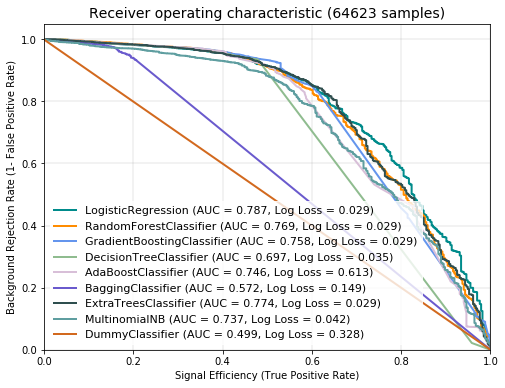

CPU times: user 22.8 s, sys: 285 ms, total: 23.1 s
Wall time: 23.8 s


In [32]:
%%time
## Assessing the various classifiers performance

dskit.plot_roc_curve(pipeline_search, X_train, X_test, y_train, y_test)

We could also explore **Precesion-Recall** plots. Recall is also know as sensitivity.

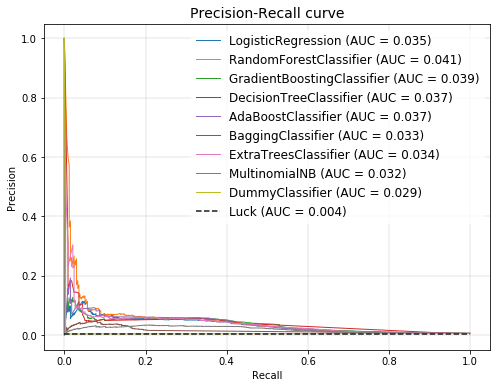

CPU times: user 7.62 s, sys: 95.1 ms, total: 7.71 s
Wall time: 7.76 s


In [33]:
%%time
# Plot precision-recall curve for several classifiers out-of-the-box

dskit.plot_precision_recall_curve(pipeline_search, 
                                  X_train, X_test, y_train, y_test)

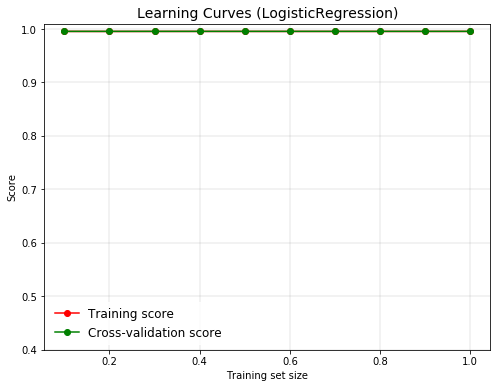

CPU times: user 36.9 s, sys: 5.09 s, total: 42 s
Wall time: 2min 11s


In [35]:
%%time
## Plot learning curve

# Cross validation with 100 iterations to get smoother mean test and train
# score curves, each time with 20% data randomly selected as a validation set.
cv = ShuffleSplit(n_splits=100, test_size=0.33, random_state=seed)

dskit.plot_learning_curve(pipeline_search["LogisticRegression"],
                          X_train, y_train, 
                          ylim=(0.4, 1.01), cv=cv, n_jobs=-1, 
                          train_sizes=np.linspace(0.1, 1.0, 10))

In [49]:
%%time

models = []
param_grid = {'learning_rate': [0.2, 1.0], 'max_depth': [1, 4]}

for params in list(ParameterGrid(param_grid)):
    model = GradientBoostingClassifier(**params)                     
    model.fit(X_train, y_train)
    models.append(model)

CPU times: user 46.6 s, sys: 679 ms, total: 47.2 s
Wall time: 48.1 s


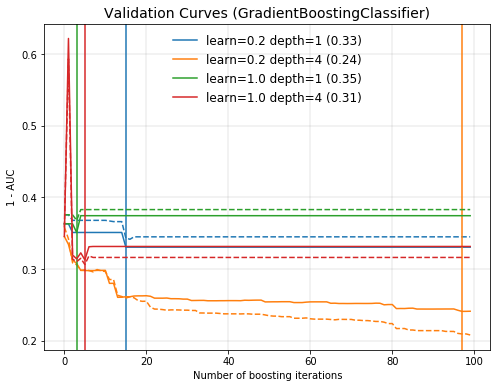

CPU times: user 9.09 s, sys: 79.2 ms, total: 9.17 s
Wall time: 9.22 s


In [50]:
%%time

# plot validation curves
dskit.plot_validation_curve(models, X_train, X_test, y_train, y_test)

## Model Building: Hyper-parameter Optimization and Model Evaluation

### Hyper-parameter Optimization and Model Evaluation

We employ a nested k-fold cross-validation utilizaiton a grid search for hyper-parameter optimization to avoid leaking information from the training dataset used to validate the hyper-parameters into the model evaluation which uses testing datasets.

We preform a hyper-parameter optimization to improve the accuary of our Gradient Boosting Classifier model then we evaluate the best cross-validated model in a hold out dataset that was not used during hyper-parameter validation.

In [54]:
%%time
## Hyper-parameter optimization and model evaluation

# construct the set of hyper-parameters to tune on
param_grid = {"n_estimators": [50], #[50, 100, 150],
              #"learning_rate": [0.01, 0.1], #[0.05, 0.1, 0.2],
              #"subsample": [0.1, 0.5], #[0.05, 0.1, 0.2,],
              'loss': ['exponential'],
              #'min_samples_leaf': [0.3, 0.5], #[0.3, 0.5],
              'max_depth': [10] #[2, 3]
             }

# Standard K-Fold cross-validation
k_fold = 3

outer_kfold_cv = KFold(n_splits=k_fold, shuffle=True, random_state=seed)
inner_kfold_cv = KFold(n_splits=k_fold-1, shuffle=True, random_state=seed)

grid = dskit.nested_grid_search_cv(GradientBoostingClassifier(),
                                   X_train, y_train,
                                   outer_kfold_cv, inner_kfold_cv,
                                   param_grid, scoring="roc_auc")

# using AUC scoring instead:
print "\nGrid-Search with AUC"
print "Best parameters:", grid.best_params_
print "Best cross-validation score (AUC): {:.3f}".format(grid.best_score_)
print "Test set AUC: {:.3f}".format(roc_auc_score(y_test, 
                                                  grid.decision_function(X_test)))
print "Test set accuracy: {:.3f}".format(grid.score(X_test, y_test))

1-fold model fitting ...
	Model validation score 0.731529753793
2-fold model fitting ...
	Model validation score 0.773324874033
3-fold model fitting ...
	Model validation score 0.706675979604
Final model evaluation (mean cross-val scores):
0.737176869143
Final fit completed

Grid-Search with AUC
Best parameters: {'n_estimators': 50, 'loss': 'exponential', 'max_depth': 10}
Best cross-validation score (AUC): 0.719
Test set AUC: 0.754
Test set accuracy: 0.754
CPU times: user 1min 11s, sys: 929 ms, total: 1min 12s
Wall time: 1min 55s


### Overfitting evaluation

#### The Kolmogorov-Smirnov statistic

We perform a two-sided asymptotic Kolmogorov-Smirnov test in which the null hypothesis stipulates that two independent samples are drawn from the same continuous parent distribution. If the K-S statistic is small or the p-value is high, then we cannot reject the hypothesis that the distributions of the two samples come from the same parent distribution. 

In essense, we reject the hypothesis that the two distributions are drawn from the same parent distribution when $D_{n_s,\ n'_s} > D^{critical}_{n_s,\ n'_s}$ or fail to reject that hypothesis otherwise.

${\displaystyle D^{critical}_{n,\ n'} = c(\alpha ){\sqrt {\frac {n + n'}{n \cdot n'}}}}$, where $n$ and $n'$ are the sizes of two samples, respectively, and

${\displaystyle c\left(\alpha \right) = {\sqrt {-{\frac {1}{2}}\ln \left({\frac {\alpha }{2}}\right)}}}$

We reject the null hypothesis at the 95% level (i.e. $\alpha=0.05$) which corresponds to $c(0.05) = 1.36$.

For signal distributions,

${\displaystyle D^{critical}_{n_s,\ n'_s} = c(\alpha ){\sqrt {\frac {n_s + n'_s}{n_s \cdot n'_s}}}}$, where $n_s$ and $n'_s$ are the sizes of training and test signal samples, respectively.

For background distributions,

${\displaystyle D^{critical}_{n_b,\ n'_b} = c(\alpha ){\sqrt {\frac {n_b + n'_b}{n_b \cdot n'_b}}}}$, where $n_b$ and $n'_b$ are the sizes of training and test background samples, respectively.

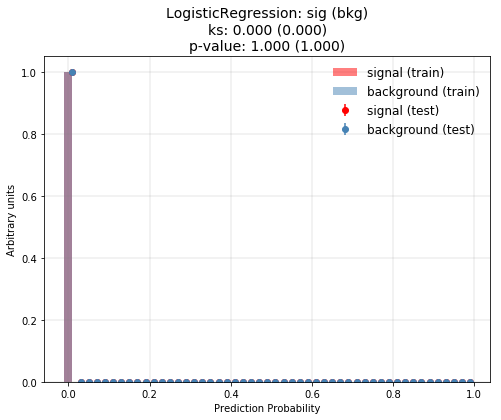

CPU times: user 36.1 s, sys: 9.82 s, total: 46 s
Wall time: 47.6 s


In [55]:
%%time
## Overfitting evaluation

# plot overfitting plot
dskit.plot_overfitting(LogisticRegression(),
                 X_train, X_test, y_train, y_test, bins=50)


LogisticRegression:
	Brier: 0.005
	Precision: 0.000
	Recall: 0.000
	F1: 0.000


LogisticRegression_Isotonic:
	Brier: 0.005
	Precision: 0.000
	Recall: 0.000
	F1: 0.000


LogisticRegression_Sigmoid:
	Brier: 0.005
	Precision: 0.000
	Recall: 0.000
	F1: 0.000



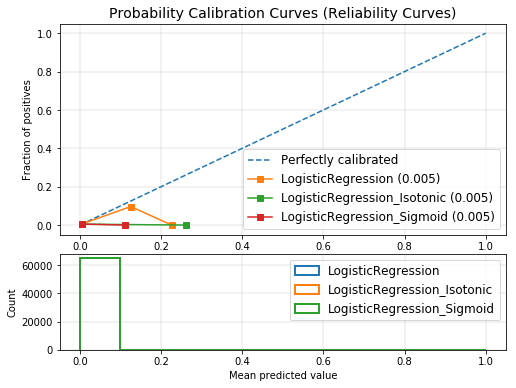

CPU times: user 637 ms, sys: 50.7 ms, total: 688 ms
Wall time: 669 ms


In [60]:
%%time
## Uncalibrated model predictions
from sklearn.naive_bayes import MultinomialNB

dskit.plot_calibration_curve(pipeline_search["LogisticRegression"],
                             X_train, X_test, y_train, y_test, 1)

## Conclusion

Having completed a comprehensive analysis on the click-through-rate data of TripleLift we conclude that the Logistic Regression Classifier gives the best predictive modeling. Studies were conducted to confirm that the model was not overfitting the data. Further studies can be performed to improve and optimise the modelling, such as using nested k-fold cross validation to obtain the best set of hyper-parameters values, well as to evaluate the final model generalizability to new data to predict on.

### Appendix

In [ ]:
%%time
## Apply the random over-sampling

ros = RandomOverSampler(random_state=seed)
X_overresampled, y_overresampled = ros.fit_sample(df_X, df_y)

# Apply the random under-sampling
rus = RandomUnderSampler(random_state=seed)
X_underresampled, y_underresampled = rus.fit_sample(df_X, df_y)

In [ ]:
# %%time
# ## Fitting a k nearest neighbor model
# kn = KNeighborsClassifier()
# kn.fit(X_train, y_train)

# # persist model
# joblib.dump(kn, 'models/KNeighborsClassifier.pkl') 

# # Evaluate model performance with log loss
# score = log_loss(y_test, kn.predict_proba(X_test))

# print "model (log loss): ", score

In [ ]:
# %%time
# ## Fitting a support vector classifier model
# sv = SVC(class_weight="balanced")
# sv.fit(X_train, y_train)

# # persist model
# joblib.dump(sv, 'models/SVC.pkl') 

# # Evaluate model performance with log loss
# score = log_loss(y_test, sv.predict_proba(X_test))

# print "model (log loss): ", score

In [ ]:
# %%time
# ## Fitting a linear discriminant analysis model
# ld = LinearDiscriminantAnalysis()
# ld.fit(X_train, y_train)

# # persist model
# joblib.dump(ld, 'models/LinearDiscriminantAnalysis.pkl') 

# # Evaluate model performance with log loss
# score = log_loss(y_test, ld.predict_proba(X_test))

# print "model (log loss): ", score